# Breakdown analysis of life cycle GHG emissions from lithium, cobalt, and graphite production routes

### Basic set-up

In [1]:
%run _imports.ipynb

BW_PROJECT = 'iri_work' # insert your project name here
bw.projects.set_current(BW_PROJECT)

EI_DB = 'ecoinvent 3.9.1 cutoff' # name of ecoinvent database in your project
METALS_DB = "EV battery metals"

IMPACT_METHODS = {
    "Climate change": ('IPCC 2021', 'climate change: including SLCFs', 'global warming potential (GWP100)')
 }

### Total life cycle GHG emissions

In [2]:
# (name, reference product, location)
INVENTORIES = {
    "Lithium, brine":        ("lithium hydroxide production, Salar de Atacama", "lithium hydroxide, battery grade", "CL"),
    "Lithium, spodumene":    ("lithium hydroxide production, from Australian spodumene", "lithium hydroxide, battery grade", "CN"),
    "Cobalt":                ("cobalt sulfate production, from copper mining, economic allocation", "cobalt sulfate", "CN"),
    "Graphite, natural":     ("natural graphite production, battery grade, from Heilongjiang", "natural graphite, battery grade", "CN"),
    "Graphite, synthetic":   ("synthetic graphite production, graphitization", "synthetic graphite, 99.9% pure", "CN")
}

In [3]:
total_ghg_emissions = {}
for metal in INVENTORIES:
    metal_ds = [ds for ds in bw.Database(METALS_DB)
                if ds['name'] == INVENTORIES[metal][0] 
                and ds['reference product'] == INVENTORIES[metal][1]
                and ds['location'] == INVENTORIES[metal][2]][0]
    
    impacts = supporting_functions.multi_lcia(metal_ds, IMPACT_METHODS)
    
    total_ghg_emissions[metal] = impacts

In [6]:
total_ghg_emissions = pd.DataFrame(total_ghg_emissions).T
total_ghg_emissions

,Climate change
"Lithium, brine",7.611945
"Lithium, spodumene",16.039000
Cobalt,12.775562
"Graphite, natural",10.707488
"Graphite, synthetic",11.080017


In [6]:
# Export total GHG emissions
#total_ghg_emissions.to_csv(DATA_DIR / "results" / f"fig1_total_ghgs_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv", index_label="Metal")

### GHG emissions breakdown analysis

In [7]:
breakdown_lists = supporting_functions.get_breakdown_lists()

In [8]:
inventories_breakdown = pd.read_excel(INVENTORIES_PATH, sheet_name="Datasets for breakdown", index_col=0, skiprows=1)
inventories_breakdown

,name,reference product,location,amount,stage
metal,,,,,
"Lithium, brine","lithium hydroxide production, Salar de Atacama","lithium hydroxide, battery grade",CL,1.000000,Refining
"Lithium, brine","lithium carbonate production, Salar de Atacama","lithium carbonate, battery grade",CL,1.050000,Refining
"Lithium, brine","lithium brine purification, Salar de Atacama",purified lithium brine,CL,22.884815,Concentration
"Lithium, brine","lithium brine production, from evaporation pon...","lithium brine, from evaporation pond",CL,3.862008,Mining
"Lithium, spodumene","lithium hydroxide production, from Australian ...","lithium hydroxide, battery grade",CN,1.000000,Refining
"Lithium, spodumene",spodumene concentrate production,spodumene concentrate,AU,6.420000,Concentration
Cobalt,"cobalt sulfate production, from copper mining,...",cobalt sulfate,CN,1.000000,Refining
Cobalt,"cobalt hydroxide, via hydrometallurigcal ore p...",cobalt hydroxide,CD,1.086800,Concentration
Cobalt,"copper-cobalt mining, industrial, economic all...",copper-cobalt ore,CD,80.423200,Mining


In [9]:
impacts_breakdown = {}

for metal in list(set(inventories_breakdown.index)):
    print(metal)
    print("------------------------")
    impacts_breakdown[metal] = {}
    skip_inventories = list(inventories_breakdown.loc[metal]["name"])

    for index, row in inventories_breakdown.loc[metal].iterrows():
        inv_amount = row["amount"]
        try:
            inv = [ds for ds in bw.Database(METALS_DB)
                if ds['name'] == row["name"]
                and ds['reference product'] == row["reference product"]
                and ds['location'] == row["location"]][0]
        except IndexError:
            inv = [ds for ds in bw.Database(EI_DB)
                if ds['name'] == row["name"]
                and ds['reference product'] == row["reference product"]
                and ds['location'] == row["location"]][0]
        
        print("..................")   
        print(inv_amount, "|", inv)
        print("..................")

        impacts_breakdown[metal][row["name"]] = supporting_functions.lcia_system_contribution(inv, skip_inventories, IMPACT_METHODS, 
                                                                                              CONTRIBUTORS_LIST, breakdown_lists, activity_amount=inv_amount)

Cobalt
------------------------
..................
1.0 | 'cobalt sulfate production, from copper mining, economic allocation' (kilogram, CN, None)
..................
..................
1.0868 | 'cobalt hydroxide, via hydrometallurigcal ore procesing, economic allocation' (kilogram, CD, None)
..................
..................
80.4232 | 'copper-cobalt mining, industrial, economic allocation' (kilogram, CD, None)
..................
Graphite, natural
------------------------
..................
1.0 | 'natural graphite production, battery grade, from Heilongjiang' (kilogram, CN, None)
..................
..................
1.01 | 'natural graphite purification' (kilogram, CN, None)
..................
..................
1.1413 | 'natural graphite spheronization' (kilogram, CN, None)
..................
..................
2.5336860000000003 | 'natural graphite concentration' (kilogram, CN, None)
..................
..................
24.298048740000002 | 'graphite ore mining' (kilogram, CN, N

In [10]:
ghgs_breakdown = {outer_key: {
    inner_key: sub_dict["Climate change"] 
    for inner_key, sub_dict in inner_dict.items()} 
    for outer_key, inner_dict in impacts_breakdown.items()
}

In [11]:
ghgs_breakdown_stages = {
        metal: { 
            stage: {
                contributor: 0 
                for contributor in CONTRIBUTORS_LIST} 
                for stage in ["Mining", "Concentration", "Refining"]}
            for metal in list(set(inventories_breakdown.index))
        }

for metal in ghgs_breakdown:
    total = 0
    for up in ghgs_breakdown[metal]:
        stage = inventories_breakdown.loc[metal][inventories_breakdown.loc[metal]["name"] == up]["stage"][0]
        for contributor in ghgs_breakdown[metal][up]:
            ghgs_breakdown_stages[metal][stage][contributor] += ghgs_breakdown[metal][up][contributor]

In [12]:
ghgs_breakdown_stages_df = pd.DataFrame([(metal, stage, source, value)
                        for metal, stage in ghgs_breakdown_stages.items()
                        for stage, source in stage.items()
                        for source, value in source.items()],
                        columns=['Metal', 'Stage', 'Source', 'Value']).set_index("Metal")

In [13]:
ghgs_breakdown_stages_df

,Stage,Source,Value
Metal,,,
Cobalt,Mining,"Direct emissions, process",0.000000
Cobalt,Mining,"Direct emissions, heat",0.000000
Cobalt,Mining,"Direct emissions, fuels",2.119550
Cobalt,Mining,Electricity consumption,0.000000
Cobalt,Mining,Fuels consumption,0.548611
...,...,...,...
"Lithium, brine",Refining,"Direct emissions, fuels",0.224870
"Lithium, brine",Refining,Electricity consumption,1.081255
"Lithium, brine",Refining,Fuels consumption,0.671206


In [14]:
# Export breakdown results
ghgs_breakdown_stages_df.to_csv(DATA_DIR / "results" / f"fig2_breakdown_ghgs_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv", index_label="Metal")

In [15]:
# Sanity check, breakdown sum vs total emissions
for metal in ghgs_breakdown_stages:
    totals = 0
    for stage in ghgs_breakdown_stages[metal]:
        for contributor in ghgs_breakdown_stages[metal][stage]:
            totals += ghgs_breakdown_stages[metal][stage][contributor]
    print(metal, totals, "|", total_ghg_emissions.loc[metal].values[0], "| Diff:", totals - total_ghg_emissions.loc[metal].values[0])

Cobalt 12.77556188332387 | 12.77556193040785 | Diff: -4.7083979382023244e-08
Graphite, natural 10.706555633132094 | 10.707487654317111 | Diff: -0.0009320211850170068
Lithium, spodumene 16.03899985990813 | 16.038999822102646 | Diff: 3.780548496479241e-08
Graphite, synthetic 12.45082117504801 | 11.08001655965439 | Diff: 1.3708046153936202
Lithium, brine 7.611945751485666 | 7.611945490573322 | Diff: 2.609123441743577e-07


### Breakdown GHG emissions from reagents consumption

In [6]:
reagents_impacts_breakdown = {}

for metal in list(set(inventories_breakdown.index)):
    print(metal)
    print("------------------------")
    reagents_impacts_breakdown[metal] = {}
    skip_inventories = list(inventories_breakdown.loc[metal]["name"])

    for index, row in inventories_breakdown.loc[metal].iterrows():
        inv_amount = row["amount"]
        try:
            inv = [ds for ds in bw.Database(METALS_DB)
                if ds['name'] == row["name"]
                and ds['reference product'] == row["reference product"]
                and ds['location'] == row["location"]][0]
        except IndexError:
            inv = [ds for ds in bw.Database(EI_DB)
                if ds['name'] == row["name"]
                and ds['reference product'] == row["reference product"]
                and ds['location'] == row["location"]][0]

        reagents_impacts_breakdown[metal][row["name"]] = supporting_functions.lcia_reagents_disaggregation(inv, skip_inventories, IMPACT_METHODS, breakdown_lists, 
                                                                                                        activity_amount=inv_amount)

Lithium, brine
------------------------
Cobalt
------------------------
Lithium, spodumene
------------------------
Graphite, natural
------------------------
Graphite, synthetic
------------------------


In [7]:
reagents_ghgs_breakdown = {outer_key: {
    inner_key: sub_dict["Climate change"] 
    for inner_key, sub_dict in inner_dict.items()} 
    for outer_key, inner_dict in reagents_impacts_breakdown.items()
}

In [8]:
reagents_ghgs_breakdown_stages = {
        metal: { 
            stage: {
                contributor: 0 
                for contributor in breakdown_lists["reagent products"]} 
                for stage in ["Mining", "Concentration", "Refining"]}
            for metal in list(set(inventories_breakdown.index))
        }

for metal in reagents_ghgs_breakdown:
    total = 0
    for up in reagents_ghgs_breakdown[metal]:
        stage = inventories_breakdown.loc[metal][inventories_breakdown.loc[metal]["name"] == up]["stage"][0]
        for contributor in reagents_ghgs_breakdown[metal][up]:
            reagents_ghgs_breakdown_stages[metal][stage][contributor] += reagents_ghgs_breakdown[metal][up][contributor]

In [11]:
reagents_ghgs_breakdown_stages_df = pd.DataFrame([(metal, stage, reagent, value)
                        for metal, stage in reagents_ghgs_breakdown_stages.items()
                        for stage, reagent in stage.items()
                        for reagent, value in reagent.items()],
                        columns=['Metal', 'Stage', 'Reagent', 'Value']).set_index("Metal")

In [12]:
reagents_ghgs_breakdown_stages_df

,Stage,Reagent,Value
Metal,,,
"Lithium, brine",Mining,"neutralising agent, sodium hydroxide-equivalent",0.0
"Lithium, brine",Mining,"hydrochloric acid, without water, in 30% solut...",0.0
"Lithium, brine",Mining,"soda ash, light",0.0
"Lithium, brine",Mining,"quicklime, milled, packed",0.0
"Lithium, brine",Mining,kerosene,0.0
...,...,...,...
"Graphite, synthetic",Refining,hydrogen fluoride,0.0
"Graphite, synthetic",Refining,pitch,0.0
"Graphite, synthetic",Refining,"nitrogen, liquid",0.0


In [13]:
# Export reagents breakdown results
reagents_ghgs_breakdown_stages_df.to_csv(DATA_DIR / "results" / f"ESI_breakdown_reagents_ghgs_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv", index_label="Metal")

In [32]:
# Standards for figures format:
# - length single column figure: 89 mm
# - length 1.5 column figure: 120-136 mm
# - length 2 columns figure: 183 mm
# - max. height figure : 247 mm

fig_length = {1:   3.50394,    # 1 column
              1.5: 5.35433,    # 1.5 columns
              2:   7.20472}    # 2 columns
fig_height = 9.72441 # maxium height
fontsize_title = 9
fontsize_label = 8
fontsize_legend = 8
fontsize_axs = 8
spineline_width = 0.6

In [218]:
df = pd.DataFrame(reagents_ghgs_breakdown_stages["Lithium, spodumene"])
df_normalized = df.div(df.values.sum()).multiply(100)
df_normalized["Total"] = df_normalized.sum(axis=1)

df_normalized

,Mining,Concentration,Refining,Total
"neutralising agent, sodium hydroxide-equivalent",0.0,0.0,0.000000,0.000000
"hydrochloric acid, without water, in 30% solution state",0.0,0.0,4.425821,4.425821
"soda ash, light",0.0,0.0,29.380188,29.380188
"quicklime, milled, packed",0.0,0.0,0.000000,0.000000
kerosene,0.0,0.0,0.000000,0.000000
sulfuric acid,0.0,0.0,15.670695,15.670695
"sodium hydroxide, without water, in 50% solution state",0.0,0.0,20.843245,20.843245
"quicklime, milled, loose",0.0,0.0,22.888773,22.888773
"hydrogen peroxide, without water, in 50% solution state",0.0,0.0,5.409943,5.409943
"carbon dioxide, liquid",0.0,0.0,1.293011,1.293011


12.45082117504801

In [247]:
df = pd.DataFrame(reagents_ghgs_breakdown_stages[metal])
df_normalized = df.div(pd.DataFrame(ghgs_breakdown_stages[metal]).sum().sum()).multiply(100)
df_normalized

,Mining,Concentration,Refining
"neutralising agent, sodium hydroxide-equivalent",0.0,0.000000,0.0
"hydrochloric acid, without water, in 30% solution state",0.0,0.000000,0.0
"soda ash, light",0.0,0.000000,0.0
"quicklime, milled, packed",0.0,0.000000,0.0
kerosene,0.0,0.000000,0.0
sulfuric acid,0.0,0.000000,0.0
"sodium hydroxide, without water, in 50% solution state",0.0,0.003972,0.0
"quicklime, milled, loose",0.0,0.000000,0.0
"hydrogen peroxide, without water, in 50% solution state",0.0,0.000000,0.0
"carbon dioxide, liquid",0.0,0.000000,0.0


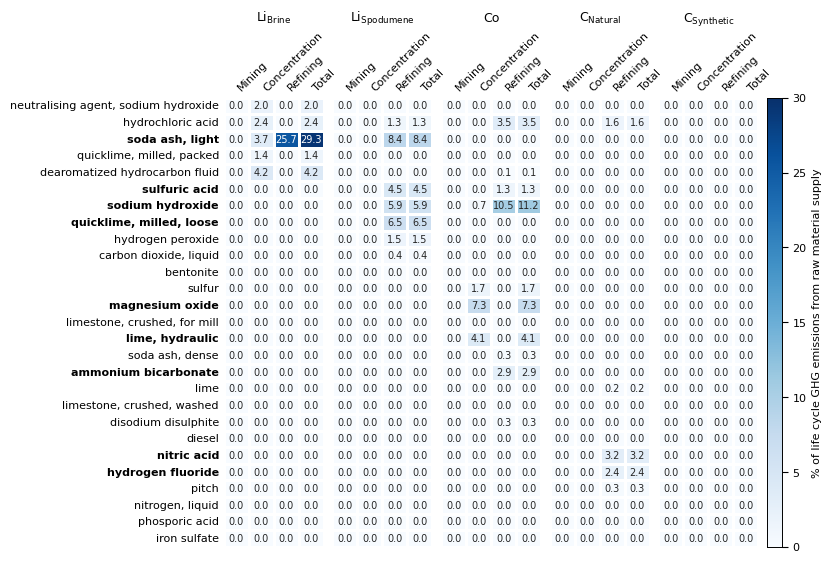

In [262]:
shorten_names = {
    "neutralising agent, sodium hydroxide-equivalent": "neutralising agent, sodium hydroxide",
    "hydrochloric acid, without water, in 30% solution state": "hydrochloric acid",
    "sodium hydroxide, without water, in 50% solution state": "sodium hydroxide",
    "hydrogen peroxide, without water, in 50% solution state": "hydrogen peroxide",
    "nitric acid, without water, in 50% solution state": "nitric acid",
    "phosphoric acid, fertiliser grade, without water, in 70% solution state": "phosporic acid",
    "kerosene": "dearomatized hydrocarbon fluid"
}

fig, axs = plt.subplot_mosaic([METALS_LIST + ["Legend"]],
                            figsize=(fig_length[2], fig_height*0.6),
                            gridspec_kw={'width_ratios': [0.2] * len(METALS_LIST) + [0.03]})

counter = 0
for metal in METALS_LIST:
    axs[metal].set_title(titles[counter], loc='center', fontsize=fontsize_title)

    df = pd.DataFrame(reagents_ghgs_breakdown_stages[metal])
    df_normalized = df.div(pd.DataFrame(ghgs_breakdown_stages[metal]).sum().sum()).multiply(100)
    df_normalized["Total"] = df_normalized.sum(axis=1)
    df_normalized = df_normalized.rename(index=shorten_names)
   # df_normalized = df_normalized[(df_normalized != 0).any(axis=1)]

    if counter == 0:
        yticklabels=True
    else:
        yticklabels=False

    sns.heatmap(ax=axs[metal], data=df_normalized, cmap="Blues", vmin=0, vmax=30, annot=True, fmt='.1f', annot_kws={"size": 7}, 
                xticklabels=True, yticklabels=yticklabels, linewidths=0.8, linecolor='white', cbar=True, cbar_ax=axs['Legend'])
    
    if counter == 0:
        for lab, annot in zip(axs[metal].get_yticklabels(), axs[metal].texts):
            text = lab.get_text()
            if text in ["soda ash, light", "kerosene", "sodium hydroxide", "sulfuric acid",
                        "quicklime, milled, loose", "magnesium oxide", "lime, hydraulic", "ammonium bicarbonate", "nitric acid", "hydrogen fluoride"]:
                # set the properties of the ticklabel
                lab.set_weight('bold')

    counter += 1
    
for col in METALS_LIST:
    axs[col].set_xticklabels(df_normalized.columns, rotation = 45, ha="left", fontsize=fontsize_axs)
    axs[col].xaxis.tick_top()
    axs[col].tick_params(axis='x', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[col].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)

    
for spine in axs["Legend"].spines.values():
    spine.set(visible=True, lw=spineline_width, edgecolor="black")
axs["Legend"].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
    
axs['Legend'].set_ylabel('% of life cycle GHG emissions from raw material supply', fontsize=fontsize_label)

fig.subplots_adjust(wspace=0.1)

plt.savefig(Path(str(r"..\reports") + '/reagents_emissions.jpg'), dpi=600, bbox_inches='tight')

In [147]:
normalize_contributions(reagents_ghgs_breakdown_stages, 'Lithium, brine')

,Mining,Concentration,Refining,Total
"neutralising agent, sodium hydroxide-equivalent",0.0,5.088460,0.000000,5.088460
"hydrochloric acid, without water, in 30% solution state",0.0,6.113945,0.000000,6.113945
"soda ash, light",0.0,9.336629,65.171155,74.507784
"quicklime, milled, packed",0.0,3.604249,0.000000,3.604249
kerosene,0.0,10.685561,0.000000,10.685561
sulfuric acid,0.0,0.000000,0.000000,0.000000
"sodium hydroxide, without water, in 50% solution state",0.0,0.000000,0.000000,0.000000
"quicklime, milled, loose",0.0,0.000000,0.000000,0.000000
"hydrogen peroxide, without water, in 50% solution state",0.0,0.000000,0.000000,0.000000
"carbon dioxide, liquid",0.0,0.000000,0.000000,0.000000
